## Relax Challenge  

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day
period, identify which factors predict future user adoption.   

We suggest spending 1-2 hours on this, but you're welcome to spend more or less.  

Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [1]:
from datetime import datetime
from datetime import timedelta
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")

The data is available as two attached CSV files:  
* takehome_user_engagement.csv  
* takehome_users.csv   

The data has the following two tables:   

1. A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:  

● name: the user's name  
● object_id: the user's id  
● email: email address  
● creation_source: how their account was created. This takes on one of 5 values:  
>    ○ PERSONAL_PROJECTS: invited to join another user's personal workspace  
>    ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)  
>    ○ ORG_INVITE: invited to an organization (as a full member)  
>    ○ SIGNUP: signed up via the website  
>    ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)  

● creation_time: when they created their account  
● last_session_creation_time: unix timestamp of last login  
● opted_in_to_mailing_list: whether they have opted into receiving  
marketing emails  
● enabled_for_marketing_drip: whether they are on the regular marketing email drip  
● org_id: the organization (group of users) they belong to  
● invited_by_user_id: which user invited them to join (if applicable).  


2.  A usage summary table ( "takehome_user_engagement" ) that has a row for each day
that a user logged into the product.

**First, load data into dataframes and inspect.**

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
users.creation_time = pd.to_datetime(users.creation_time)

In [5]:
users['last_session_creation_time'] = pd.to_datetime(users.last_session_creation_time, unit='s', errors='coerce')

In [6]:
users.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0


In [7]:
users.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,0.432742,0.356432,124.056723,3383.761968
min,1.00000,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000


In [8]:
users.object_id.nunique()

12000

In [9]:
usage = pd.read_csv("takehome_user_engagement.csv")

In [10]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [11]:
usage.time_stamp = pd.to_datetime(usage.time_stamp)

In [12]:
usage.tail(20)

,time_stamp,user_id,visited
207897,2014-05-21 11:04:47,11988,1
207898,2014-05-23 11:04:47,11988,1
207899,2014-05-24 11:04:47,11988,1
207900,2014-05-26 11:04:47,11988,1
207901,2014-05-27 11:04:47,11988,1
207902,2014-06-01 11:04:47,11988,1
207903,2013-09-07 11:24:33,11989,1
207904,2013-07-06 21:00:48,11990,1
207905,2014-04-20 14:22:45,11991,1
207906,2014-04-25 14:22:45,11991,1


Looks like the data is sorted, but sort it to make sure calculations are correct. Neither user_id nor time_stamp is an index so cannot count on data being ordered as necessary. 

In [13]:
usage = usage.sort_values(by=['user_id', 'time_stamp'])

In [14]:
usage.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


Visited is an odd column as every row has the same value. 

In [15]:
usage.user_id.nunique()

8823

The number of unique user_id values in usage matches the number of last_session_creation_time values in users. That is encouraging as it suggests clean data. 

**1. Find time frame of 3 consecutive logins.**  


Find time difference between each login and two logins ago, by user. This gives time frame of 3 consecutive logins and will be used to define "adopted user".

In [16]:
def time_difference(group):
    group['time_for_three'] = group['time_stamp'].diff(periods=2)
    return group

usage = usage.groupby('user_id').apply(time_difference)

In [17]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype          
---  ------          --------------   -----          
 0   time_stamp      207917 non-null  datetime64[ns] 
 1   user_id         207917 non-null  int64          
 2   visited         207917 non-null  int64          
 3   time_for_three  196506 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), int64(2), timedelta64[ns](1)
memory usage: 7.9 MB


**2. Define "adopted user".**  

Time difference over any 3 consecutive logins <= 7 days defines adopted user.**

In [18]:
min_usage_by_user = usage.groupby('user_id')['time_for_three'].min()
min_usage_by_user[min_usage_by_user <= timedelta(days=7)]

user_id
2       5 days
10      2 days
20      2 days
33      6 days
42      2 days
         ...  
11965   3 days
11967   2 days
11969   2 days
11975   2 days
11988   2 days
Name: time_for_three, Length: 1656, dtype: timedelta64[ns]

In [19]:
min_usage_by_user[min_usage_by_user > timedelta(days=7)]

user_id
59      83 days
77      28 days
95      16 days
126     19 days
136     15 days
          ...  
11948   31 days
11949    9 days
11980    9 days
11981   12 days
11991    8 days
Name: time_for_three, Length: 592, dtype: timedelta64[ns]

In [20]:
min_usage_by_user[min_usage_by_user.isnull()]

user_id
1       NaT
3       NaT
4       NaT
5       NaT
6       NaT
         ..
11996   NaT
11997   NaT
11998   NaT
11999   NaT
12000   NaT
Name: time_for_three, Length: 6575, dtype: timedelta64[ns]

**3. Review results.**  

Most users have not logged in three times, so they have a null value for the time period for three logins. Of those who have logged in three times, there are twice as many are adopted users as not. 

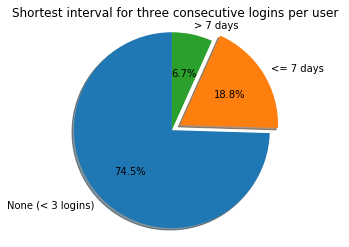

In [21]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'None (< 3 logins)', '<= 7 days', '> 7 days'
sizes = [min_usage_by_user.isnull().sum(), 
         (min_usage_by_user <= timedelta(days=7)).sum(), 
         (min_usage_by_user > timedelta(days=7)).sum()]
         
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Shortest interval for three consecutive logins per user')

plt.show()

In [22]:
merged = pd.merge(users, usage, how='left', left_on='object_id', right_on='user_id', validate= '1:m')

In [23]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   object_id                   211094 non-null  int64          
 1   creation_time               211094 non-null  datetime64[ns] 
 2   name                        211094 non-null  object         
 3   email                       211094 non-null  object         
 4   creation_source             211094 non-null  object         
 5   last_session_creation_time  207917 non-null  datetime64[ns] 
 6   opted_in_to_mailing_list    211094 non-null  int64          
 7   enabled_for_marketing_drip  211094 non-null  int64          
 8   org_id                      211094 non-null  int64          
 9   invited_by_user_id          118528 non-null  float64        
 10  time_stamp                  207917 non-null  datetime64[ns] 
 11  user_id                   

In [24]:
merged.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visited,time_for_three
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,2014-04-22 03:53:30,1.0,1.0,NaT
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-15 03:45:04,2.0,1.0,NaT
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-29 03:45:04,2.0,1.0,NaT
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-09 03:45:04,2.0,1.0,24 days
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-25 03:45:04,2.0,1.0,26 days
5,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-31 03:45:04,2.0,1.0,22 days
6,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2014-01-08 03:45:04,2.0,1.0,14 days
7,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2014-02-03 03:45:04,2.0,1.0,34 days
8,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2014-02-08 03:45:04,2.0,1.0,31 days
9,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2014-02-09 03:45:04,2.0,1.0,6 days


In [25]:
last_time_check = merged[['object_id', 'last_session_creation_time', 'time_stamp']].groupby('object_id').max()
last_time_check

,last_session_creation_time,time_stamp
object_id,,
1,2014-04-22 03:53:30,2014-04-22 03:53:30
2,2014-03-31 03:45:04,2014-03-31 03:45:04
3,2013-03-19 23:14:52,2013-03-19 23:14:52
4,2013-05-22 08:09:28,2013-05-22 08:09:28
5,2013-01-22 10:14:20,2013-01-22 10:14:20
...,...,...
11996,2013-09-06 06:14:15,2013-09-06 06:14:15
11997,2013-01-15 18:28:37,2013-01-15 18:28:37
11998,2014-04-27 12:45:16,2014-04-27 12:45:16


In [26]:
last_time_check[last_time_check.last_session_creation_time.notnull() & 
           (last_time_check.last_session_creation_time != last_time_check.time_stamp)]

,last_session_creation_time,time_stamp
object_id,,


In [27]:
merged[merged['user_id'].isnull()].count()

object_id                     3177
creation_time                 3177
name                          3177
email                         3177
creation_source               3177
last_session_creation_time       0
opted_in_to_mailing_list      3177
enabled_for_marketing_drip    3177
org_id                        3177
invited_by_user_id            1641
time_stamp                       0
user_id                          0
visited                          0
time_for_three                   0
dtype: int64

In [28]:
def adopt_user(group):
    group['adopted_user'] = np.where(group['time_for_three'].min() <= timedelta(days=7), 1, 0)
    group['login_count'] = group['time_stamp'].count()
    group['first_login_delta_hours'] = (group['time_stamp'].min() - group['creation_time']) // pd.Timedelta(hours=1)
    group['last_login_delta_hours'] = (group['time_stamp'].max() - group['creation_time']) // pd.Timedelta(hours=1)
    return group

merged = merged.groupby('object_id').apply(adopt_user)

In [29]:
merged[['object_id', 'user_id', 'login_count', 'time_for_three', 'adopted_user', 
        'first_login_delta_hours', 'last_login_delta_hours']].groupby('object_id').min().head(20)

,user_id,login_count,time_for_three,adopted_user,first_login_delta_hours,last_login_delta_hours
object_id,,,,,,
1,1.0,1,NaT,0,0.0,0.0
2,2.0,14,5 days,1,0.0,3264.0
3,3.0,1,NaT,0,0.0,0.0
4,4.0,1,NaT,0,24.0,24.0
5,5.0,1,NaT,0,120.0,120.0
6,6.0,1,NaT,0,48.0,48.0
7,7.0,1,NaT,0,96.0,96.0
8,NaN,0,NaT,0,NaN,NaN
9,NaN,0,NaT,0,NaN,NaN


In [30]:
merged[(merged.login_count > 3) & (merged.adopted_user == 0)].describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,visited,time_for_three,adopted_user,login_count,first_login_delta_hours,last_login_delta_hours
count,1979.00000,1979.000000,1979.000000,1979.000000,1209.000000,1979.00000,1979.0,1259,1979.0,1979.000000,1979.000000,1979.000000
mean,5915.19050,0.240526,0.158161,160.509853,6078.649297,5915.19050,1.0,23 days 17:49:25.210484,0.0,6.198585,22.338555,1506.445680
std,3566.74873,0.427511,0.364984,119.194114,3324.026073,3566.74873,0.0,14 days 11:42:47.282486,0.0,2.423861,33.149058,835.570004
min,95.00000,0.000000,0.000000,0.000000,108.000000,95.00000,1.0,8 days 00:00:00,0.0,4.000000,0.000000,264.000000
25%,2746.00000,0.000000,0.000000,52.000000,3247.000000,2746.00000,1.0,13 days 00:00:00,0.0,4.000000,0.000000,984.000000
50%,5761.00000,0.000000,0.000000,139.000000,6202.000000,5761.00000,1.0,20 days 00:00:00,0.0,5.000000,0.000000,1296.000000
75%,9196.00000,0.000000,0.000000,242.000000,8830.000000,9196.00000,1.0,30 days 00:00:00,0.0,7.000000,24.000000,1896.000000
max,11991.00000,1.000000,1.000000,415.000000,11966.000000,11991.00000,1.0,124 days 00:00:00,0.0,15.000000,192.000000,4536.000000


In [31]:
feat_cols = ['object_id', 'creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time', 
             'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted_user', 
             'login_count', 'first_login_delta_hours', 'last_login_delta_hours']
features = merged[feat_cols]
features = features.groupby('object_id').max()
features.shape

(12000, 13)

In [32]:
features['adopted_user'] = features['adopted_user'].astype('category')

In [33]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  object        
 2   email                       12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
 9   adopted_user                12000 non-null  category      
 10  login_count                 12000 non-null  int32         
 11  first_login_delta_hours     8823 non-null   float64   

**Look at feature data.**

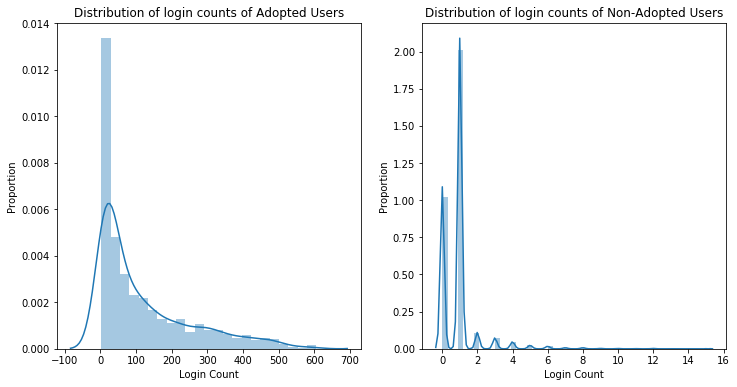

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.distplot(features[features.adopted_user == 1].login_count, ax=ax1)
ax1.set_title('Distribution of login counts of Adopted Users')
ax1.set_ylabel('Proportion')
ax1.set_xlabel('Login Count')

sns.distplot(features[features.adopted_user == 0].login_count, ax=ax2)
ax2.set_title('Distribution of login counts of Non-Adopted Users')
ax2.set_ylabel('Proportion')
ax2.set_xlabel('Login Count')
plt.show()

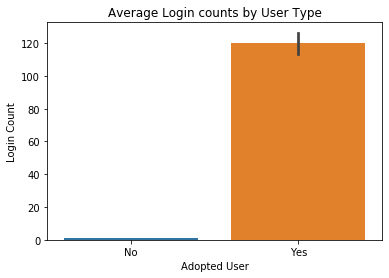

In [36]:
sns.barplot(x='adopted_user', y='login_count', data=features, orient='v')
plt.title('Average Login counts by User Type')
plt.xticks([0, 1], labels=['No', 'Yes'])
plt.xlabel('Adopted User')
plt.ylabel('Login Count')
plt.show()

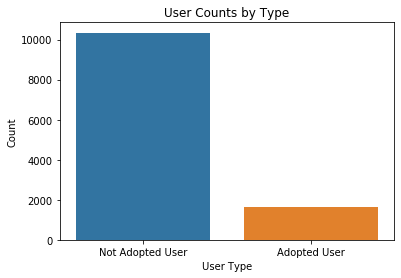

In [37]:
sns.countplot(x='adopted_user', data=features)
plt.title('User Counts by Type')
plt.ylabel('Count')
plt.xlabel('User Type')
plt.xticks([0, 1], labels=['Not Adopted User', 'Adopted User'])
plt.show()

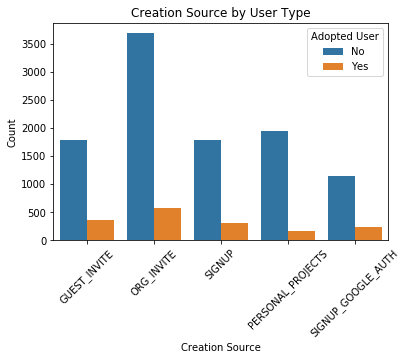

In [38]:
sns.countplot(x='creation_source', hue='adopted_user', data=features)
plt.title('Creation Source by User Type')
plt.ylabel('Count')
plt.xlabel('Creation Source')
plt.xticks(rotation=45)
plt.legend(('No', 'Yes'), title='Adopted User')
plt.show()

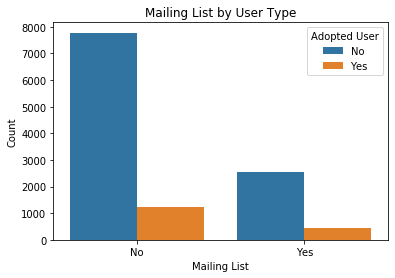

In [39]:
sns.countplot(x='opted_in_to_mailing_list', hue='adopted_user', data=features)
plt.title('Mailing List by User Type')
plt.ylabel('Count')
plt.xlabel('Mailing List')
plt.xticks([0, 1], labels=['No', 'Yes'])
plt.legend(('No', 'Yes'), title='Adopted User')
plt.show()

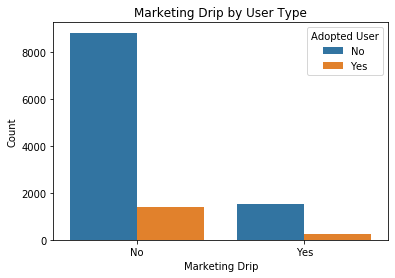

In [40]:
sns.countplot(x='enabled_for_marketing_drip', hue='adopted_user', data=features)
plt.title('Marketing Drip by User Type')
plt.ylabel('Count')
plt.xlabel('Marketing Drip')
plt.xticks([0, 1], labels=['No', 'Yes'])
plt.legend(('No', 'Yes'), title='Adopted User')
plt.show()

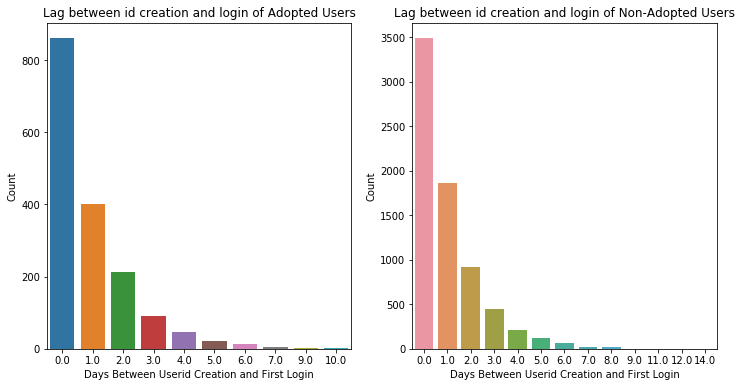

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.countplot(features[features.adopted_user == 1].first_login_delta_hours/24, ax=ax1)
ax1.set_title('Lag between id creation and login of Adopted Users')
ax1.set_ylabel('Count')
ax1.set_xlabel('Days Between Userid Creation and First Login')

sns.countplot(features[features.adopted_user == 0].first_login_delta_hours/24, ax=ax2)
ax2.set_title('Lag between id creation and login of Non-Adopted Users')
ax2.set_ylabel('Count')
ax2.set_xlabel('Days Between Userid Creation and First Login')
plt.show()

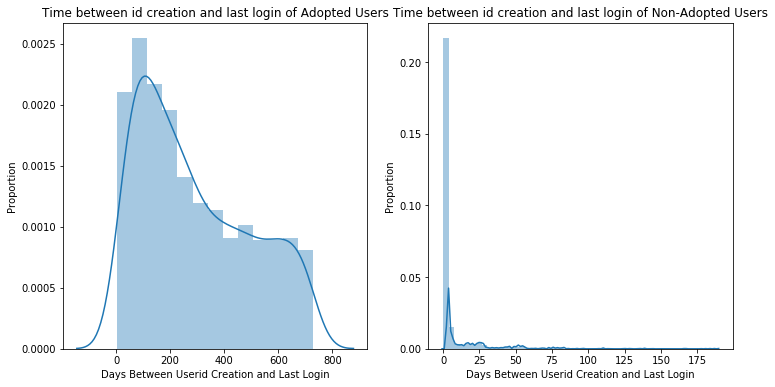

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.distplot(features[features.adopted_user == 1].last_login_delta_hours/24, ax=ax1)
ax1.set_title('Time between id creation and last login of Adopted Users')
ax1.set_ylabel('Proportion')
ax1.set_xlabel('Days Between Userid Creation and Last Login')

sns.distplot(features[features.adopted_user == 0].last_login_delta_hours/24, ax=ax2)
ax2.set_title('Time between id creation and last login of Non-Adopted Users')
ax2.set_ylabel('Proportion')
ax2.set_xlabel('Days Between Userid Creation and Last Login')
plt.show()

#### Data preprocessing for modeling. 

1. Engineer features from email address, dates.
2. Change dates to epoch times. 
3. Change missing invited_by_user_id to 0.
4. Change missing last_session_creation_time, last_login_delta_hours to 0. 
5. Change missing first_login_delta_hours to -1. 
6. Convert categoricals to dummies.
7. Scale numerics.

In [43]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  object        
 2   email                       12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
 9   adopted_user                12000 non-null  category      
 10  login_count                 12000 non-null  int32         
 11  first_login_delta_hours     8823 non-null   float64   

In [44]:
def domain_split(x):
    try:
        return x.split('@')[1]
    except:
        return ''
features['email_domain'] = features['email'].apply(domain_split)

In [45]:
features.email_domain.value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
                  ... 
escgx.com            1
btsil.com            1
hdsjq.com            1
mxdxf.com            1
qexea.com            1
Name: email_domain, Length: 1184, dtype: int64

In [46]:
features.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [47]:
features['creation_time_epoch'] = (features['creation_time'] - datetime(1970,1,1)) // pd.Timedelta('1s')
features['creation_time_epoch']

object_id
1        1398138810
2        1384487104
3        1363734892
4        1369123768
5        1358417660
            ...    
11996    1378448055
11997    1357842517
11998    1398602716
11999    1338465359
12000    1390726632
Name: creation_time_epoch, Length: 12000, dtype: int64

In [48]:
features['last_session_creation_time_epoch'] = (features['last_session_creation_time'] 
                                                - datetime(1970,1,1)) // pd.Timedelta('1s')
features['last_session_creation_time_epoch']

object_id
1        1.398139e+09
2        1.396238e+09
3        1.363735e+09
4        1.369210e+09
5        1.358850e+09
             ...     
11996    1.378448e+09
11997    1.358275e+09
11998    1.398603e+09
11999    1.338638e+09
12000    1.390727e+09
Name: last_session_creation_time_epoch, Length: 12000, dtype: float64

In [49]:
features.loc[features['last_session_creation_time_epoch'].isnull(), 'last_session_creation_time_epoch'] = 0

In [50]:
features.loc[features['first_login_delta_hours'].isnull(), 'first_login_delta_hours'] = -1

In [51]:
features.loc[features['last_login_delta_hours'].isnull(), 'last_login_delta_hours'] = 0

In [52]:
features.loc[features['invited_by_user_id'].isnull(), 'invited_by_user_id'] = 0

In [53]:
features['last_session_day_of_week'] = features['last_session_creation_time'].dt.dayofweek
features['last_session_day_of_week'].value_counts()

2.0    1494
1.0    1290
3.0    1227
4.0    1210
0.0    1208
6.0    1205
5.0    1189
Name: last_session_day_of_week, dtype: int64

In [54]:
features['creation_time_day_of_week'] = features['creation_time'].dt.dayofweek
features['creation_time_day_of_week'].value_counts()

4    1822
3    1803
0    1712
2    1689
5    1661
6    1657
1    1656
Name: creation_time_day_of_week, dtype: int64

In [55]:
ml_features = features.drop(columns=['creation_time', 'name', 'email', 'last_session_creation_time'])

In [56]:
ml_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   creation_source                   12000 non-null  object  
 1   opted_in_to_mailing_list          12000 non-null  int64   
 2   enabled_for_marketing_drip        12000 non-null  int64   
 3   org_id                            12000 non-null  int64   
 4   invited_by_user_id                12000 non-null  float64 
 5   adopted_user                      12000 non-null  category
 6   login_count                       12000 non-null  int32   
 7   first_login_delta_hours           12000 non-null  float64 
 8   last_login_delta_hours            12000 non-null  float64 
 9   email_domain                      12000 non-null  object  
 10  creation_time_epoch               12000 non-null  int64   
 11  last_session_creation_time_epoch  12000 non-null  floa

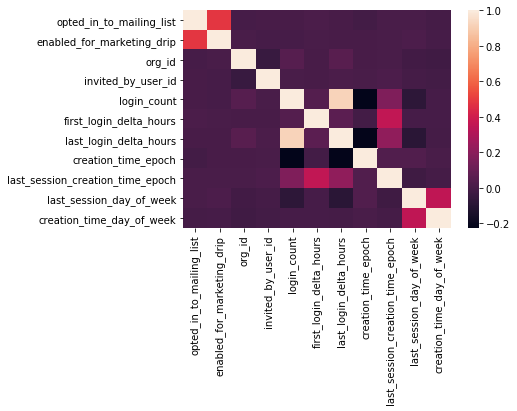

In [63]:
corr = ml_features.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

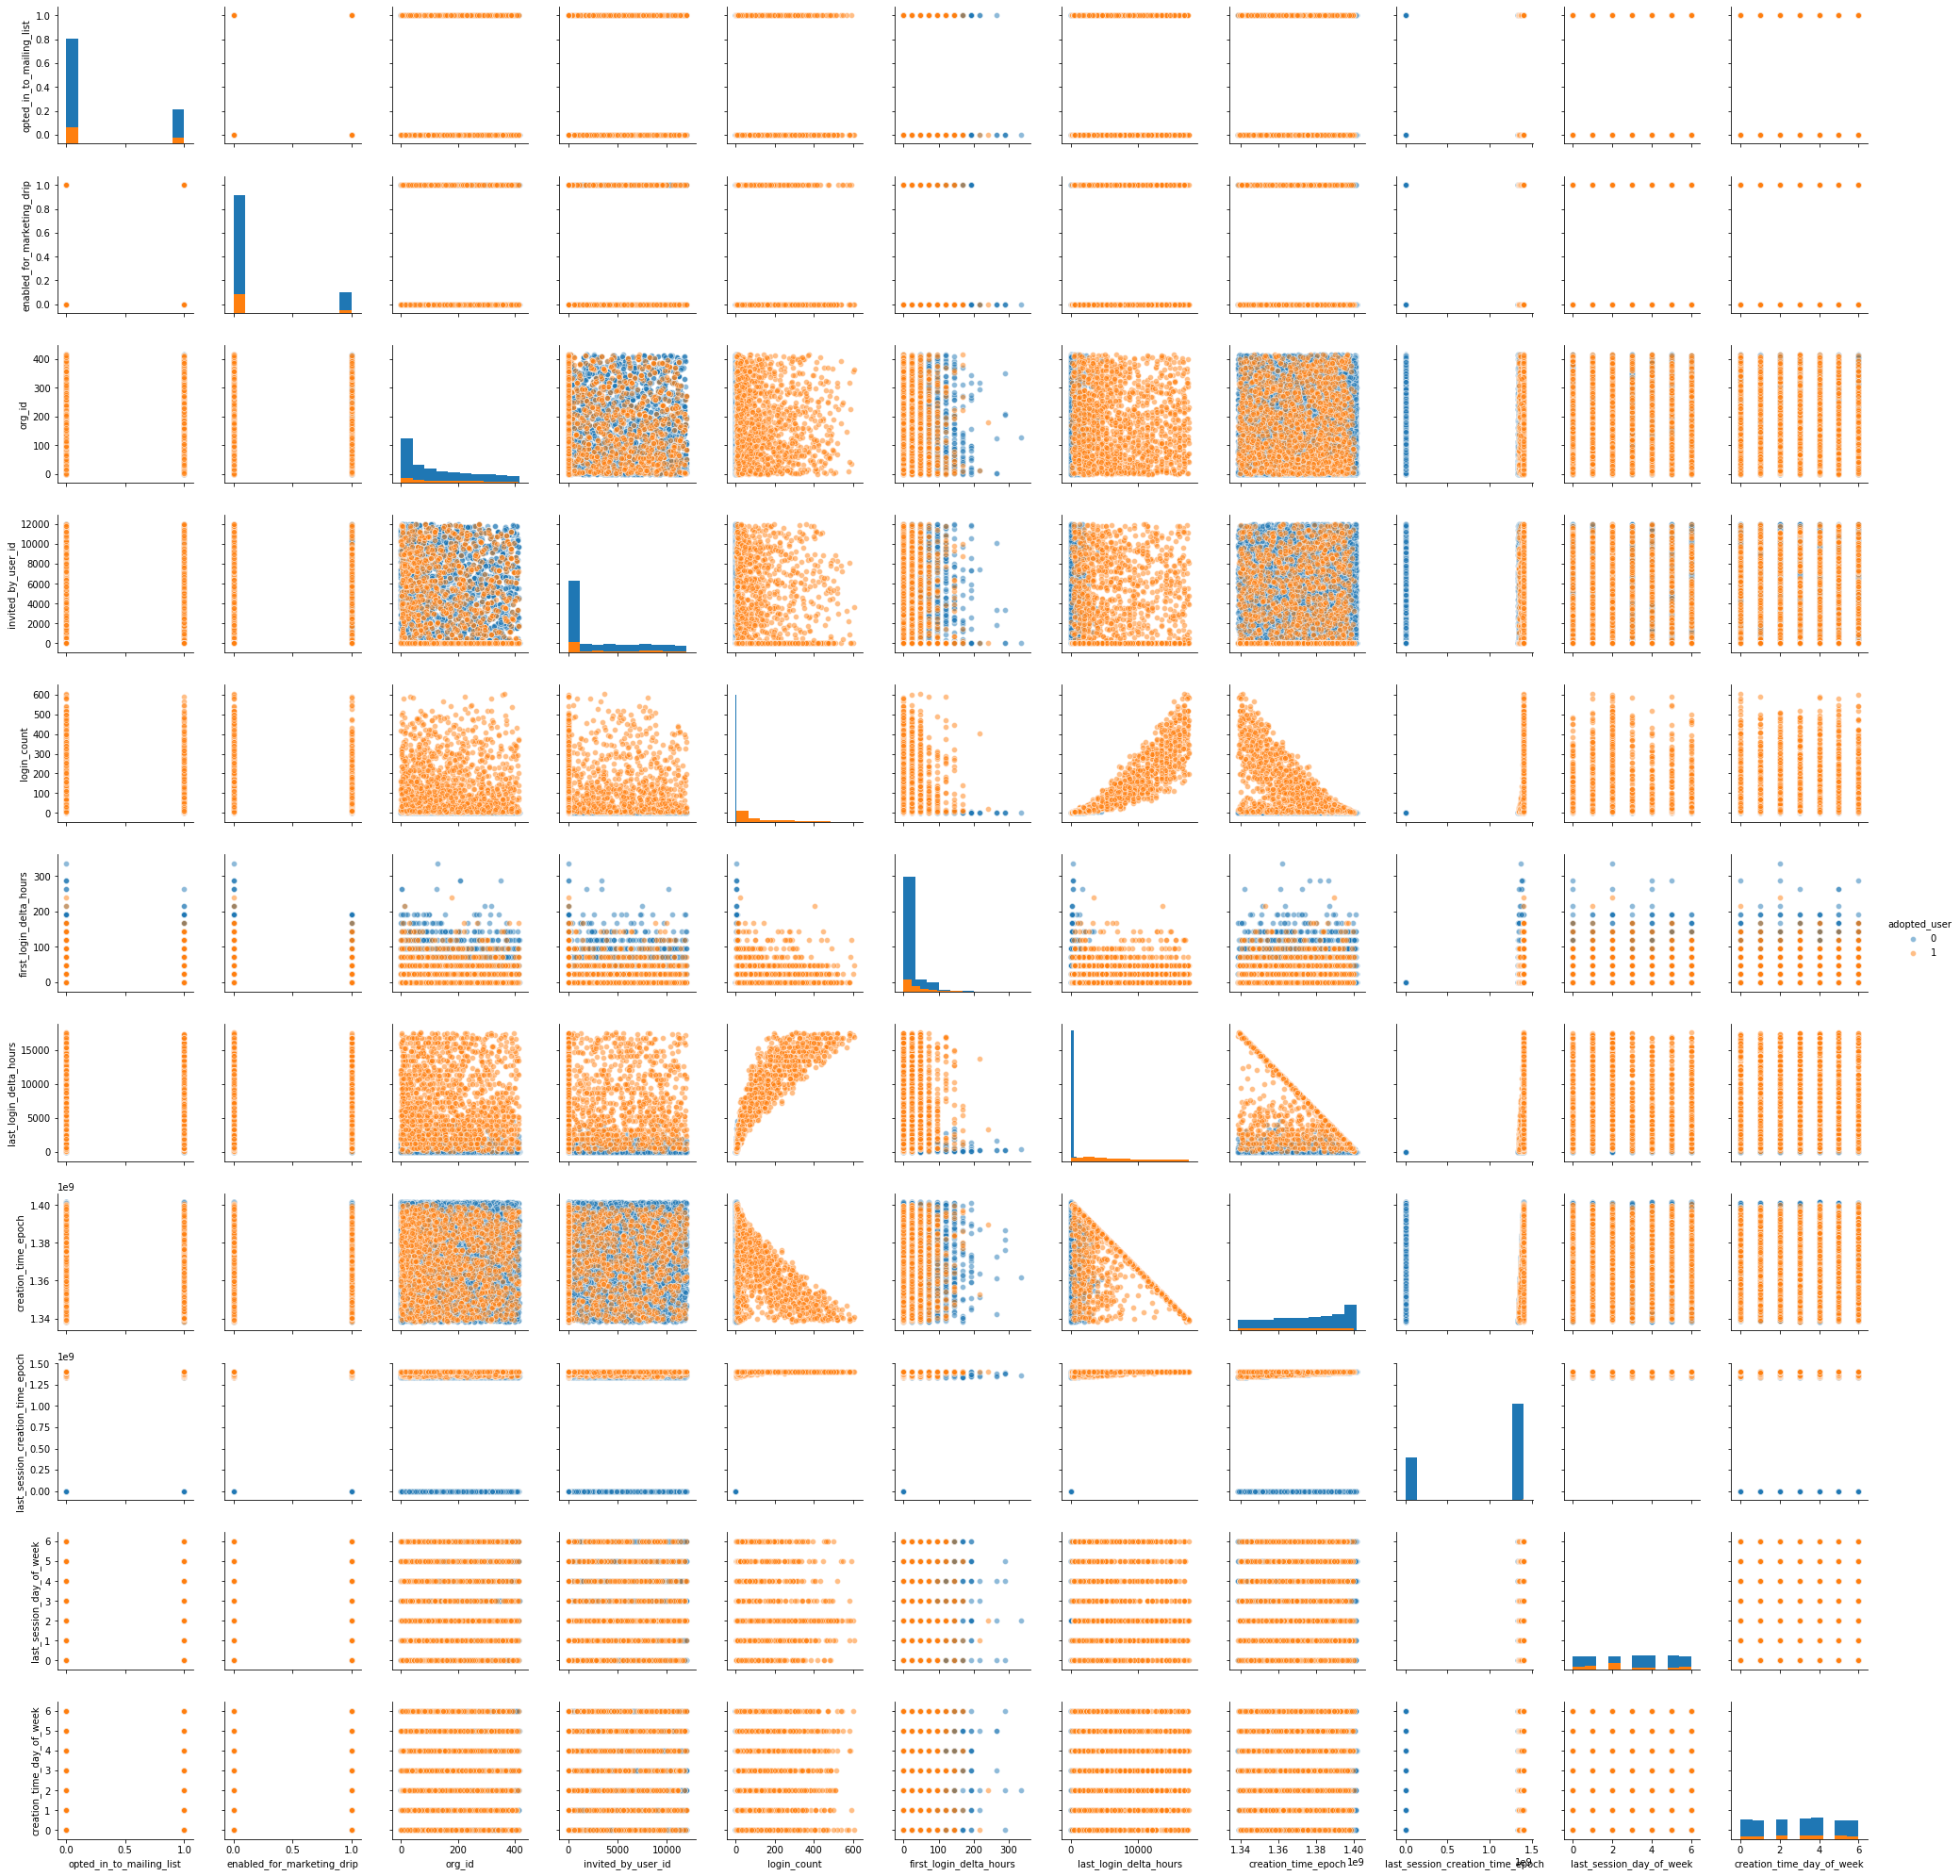

In [87]:
# kde throws errors so look at stacked histograms for diagonals. 
sns.pairplot(features, hue='adopted_user', diag_kind='hist', plot_kws={'alpha':0.5})
plt.show()

In [57]:
labels = ml_features['adopted_user']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(ml_features, labels, test_size=0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8400, 14), (8400,), (3600, 14), (3600,))

In [59]:
cont_cols = ['login_count', 'first_login_delta_hours', 'last_login_delta_hours', 'creation_time_epoch', 
             'last_session_creation_time_epoch']
scaler = StandardScaler()
# convert back to dataframe to concat w dummy columns. 
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train[cont_cols]))
scaled_X_test = pd.DataFrame(scaler.transform(X_test[cont_cols]))
scaled_X_train.columns = cont_cols
scaled_X_train.index = X_train.index
scaled_X_test.columns = cont_cols
scaled_X_test.index = X_test.index

In [60]:
from pandas.api.types import CategoricalDtype
cat_cols = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 
            'email_domain', 'creation_time_day_of_week', 'last_session_day_of_week']
X_train_dummy = X_train.loc[:,cat_cols].apply(lambda x: x.astype('category'))
# Get categories from train set to define categories in test set. 
X_train_cats = {col: CategoricalDtype(categories=X_train_dummy[col].cat.categories.to_list()) \
                for col in X_train_dummy.columns}
# Now convert category column to dummy variables for modeling. 
X_train_dummy = pd.get_dummies(X_train_dummy)
X_train_dummy.index = X_train.index

# Use train categories on test data. Will drop any values not in category list. 
X_test_dummy = X_test.loc[:,cat_cols]
X_test_dummy = X_test_dummy.astype(X_train_cats)
X_test_dummy = pd.get_dummies(X_test_dummy, columns=cat_cols)
X_test_dummy.index = X_test.index

# Get columns from training that are missing in test as fewer values in test for get_dummies.
missing_cols = set(X_train_dummy.columns) - set(X_test_dummy.columns)
# Add each missing column to test set with value equal to 0.
for c in missing_cols:
    X_test_dummy[c] = 0
# Ensure the order of columns in the test set is the same as in train set.
X_test_dummy = X_test_dummy[X_train_dummy.columns]

In [61]:
X_train_processed = pd.concat([scaled_X_train, X_train_dummy], axis=1)
X_test_processed = pd.concat([scaled_X_test, X_test_dummy], axis=1)

**Logistic Regression**

In [74]:
# Drop last_login_delta_hours, login_count for consecutive runs and see how model feature importance changes. They are 
#   correlated, so will affect coefficient calculation in regression. 
X_train_processed_lr = X_train_processed.drop(columns=['last_login_delta_hours'])
X_test_processed_lr = X_test_processed.drop(columns=['last_login_delta_hours'])

In [75]:
class_names = ['Not Adopted', 'Adopted']
logreg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)
logreg.fit(X_train_processed_lr, y_train)
y_pred = logreg.predict(X_test_processed_lr)
print(classification_report(y_pred, y_test, target_names = class_names))

              precision    recall  f1-score   support

 Not Adopted       1.00      0.98      0.99      3151
     Adopted       0.89      0.97      0.93       449

    accuracy                           0.98      3600
   macro avg       0.94      0.98      0.96      3600
weighted avg       0.98      0.98      0.98      3600



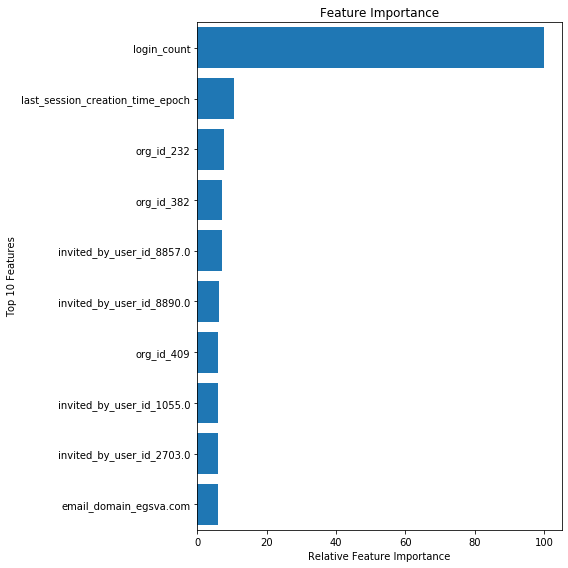

In [76]:
# Look at top 10 features
def plot_top_features_coef(clf, X_train, n_features, n_coef):
    """
    Plot top features from a classifier that has a coef_ attribute. 
    
    Input:
            clf:        classifier having a coef_ attribute
            X_train:    training dataset, used to get feature names
            n_features: number of features to plot
            n_coef:     index of coef_ to plot
    """
    feature_importance = abs(clf.coef_[n_coef])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)

    top_features = feature_importance[np.argsort(feature_importance)[-n_features:]]
    top_labels = X_train.columns[np.argsort(feature_importance)[-n_features:]]
    pos = np.arange(top_features.shape[0]) + .5

    featfig = plt.figure(figsize = (8, 8))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, top_features)
    featax.set_yticks(pos)
    featax.set_yticklabels(top_labels, fontsize=10)
    featax.set_ylim(0, n_features)
    featax.set_xlabel('Relative Feature Importance')
    ylab = 'Top ' + str(n_features) + ' Features'
    featax.set_ylabel(ylab)
    featax.set_title('Feature Importance')

    plt.tight_layout()   
    plt.show()

plot_top_features_coef(logreg, X_train_processed_lr, 10, 0)

In [89]:
X_train_processed_lr = X_train_processed.drop(columns=['login_count', 'last_login_delta_hours'])
X_test_processed_lr = X_test_processed.drop(columns=['login_count', 'last_login_delta_hours'])

In [90]:
class_names = ['Not Adopted', 'Adopted']
logreg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)
logreg.fit(X_train_processed_lr, y_train)
y_pred = logreg.predict(X_test_processed_lr)
print(classification_report(y_pred, y_test, target_names = class_names))

              precision    recall  f1-score   support

 Not Adopted       0.86      0.95      0.90      2824
     Adopted       0.71      0.45      0.55       776

    accuracy                           0.84      3600
   macro avg       0.78      0.70      0.73      3600
weighted avg       0.83      0.84      0.83      3600



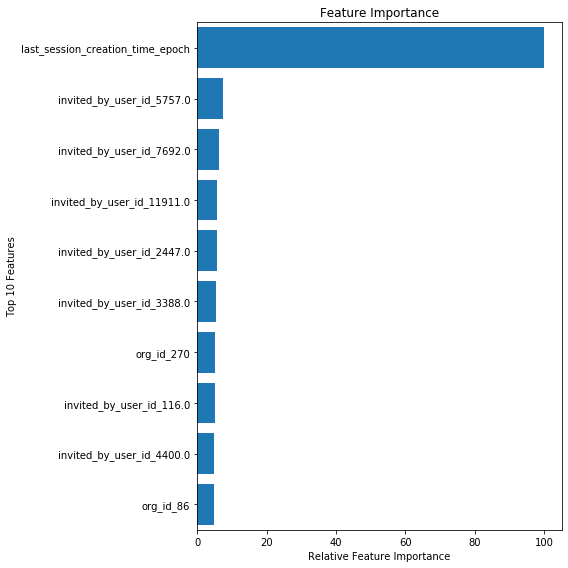

In [91]:
plot_top_features_coef(logreg, X_train_processed_lr, 10, 0)

LR w login_count gives best results. LR w last_login_delta_hours gives close results with F1-score of Adopted = 0.88. Taking both features out of model gives F1-score of Adopted = 0.55, with top feature = last_session_creation_time_epoch. 

**Gradient Boosting**

In [77]:
class_names = ['Not Adopted', 'Adopted']
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_processed, y_train)
y_pred = gb.predict(X_test_processed)
print(classification_report(y_pred, y_test, target_names = class_names))

              precision    recall  f1-score   support

 Not Adopted       0.99      0.99      0.99      3108
     Adopted       0.96      0.96      0.96       492

    accuracy                           0.99      3600
   macro avg       0.98      0.98      0.98      3600
weighted avg       0.99      0.99      0.99      3600



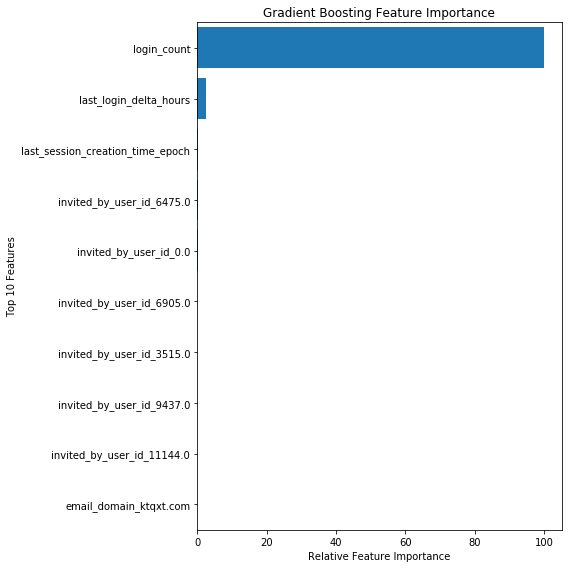

In [78]:
def plot_top_features_imp(clf, X_train, n_features):
    """
    Plot top features from a classifier that has a feature_importances_ attribute. 
    
    Input:
            clf:        classifier having a feature_importances_ attribute
            X_train:    training dataset, used to get feature names
            n_features: number of features to plot
    """
    
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)

    top_features = feature_importance[np.argsort(feature_importance)[-n_features:]]
    top_labels = X_train.columns[np.argsort(feature_importance)[-n_features:]]
    pos = np.arange(top_features.shape[0]) + .5

    featfig = plt.figure(figsize = (8, 8))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, top_features)
    featax.set_yticks(pos)
    featax.set_yticklabels(top_labels, fontsize=10)
    featax.set_ylim(0, n_features)
    featax.set_xlabel('Relative Feature Importance')
    ylab = 'Top ' + str(n_features) + ' Features'
    featax.set_ylabel(ylab)
    featax.set_title('Gradient Boosting Feature Importance')

    plt.tight_layout()   
    plt.show()

plot_top_features_imp(gb, X_train_processed, 10)

In [83]:
result = permutation_importance(gb, X_test_processed, y_test, n_repeats=10, random_state=0)

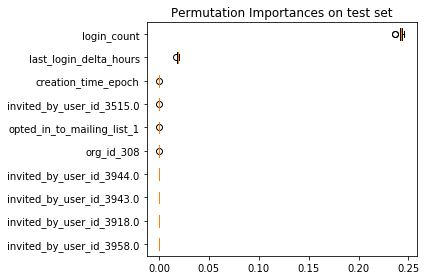

In [84]:
n_features=10
sorted_idx = result.importances_mean.argsort()

top_features = result.importances[sorted_idx[-n_features:]]
top_labels = X_test_processed.columns[sorted_idx[-n_features:]]

fig, ax = plt.subplots()
ax.boxplot(top_features.T,
           vert=False, labels=top_labels)
ax.set_title("Permutation Importances on test set")
fig.tight_layout()
plt.show()

Gradient Boosting Feature importance and Permutation Importance agree. Login_count is by far the most important feature, wtih time between userid creation and last login a distant second. 

#### Login count dominates feature importance. Drop it as a feature to see what we can glean from other features. 

In [79]:
X_train_processed_2 = X_train_processed.drop(columns='login_count')
X_test_processed_2 = X_test_processed.drop(columns='login_count')

In [80]:
class_names = ['Not Adopted', 'Adopted']
gb2 = GradientBoostingClassifier(random_state=42)
gb2.fit(X_train_processed_2, y_train)
y_pred_2 = gb2.predict(X_test_processed_2)
print(classification_report(y_pred_2, y_test, target_names = class_names))

              precision    recall  f1-score   support

 Not Adopted       0.99      0.98      0.98      3136
     Adopted       0.87      0.92      0.89       464

    accuracy                           0.97      3600
   macro avg       0.93      0.95      0.94      3600
weighted avg       0.97      0.97      0.97      3600



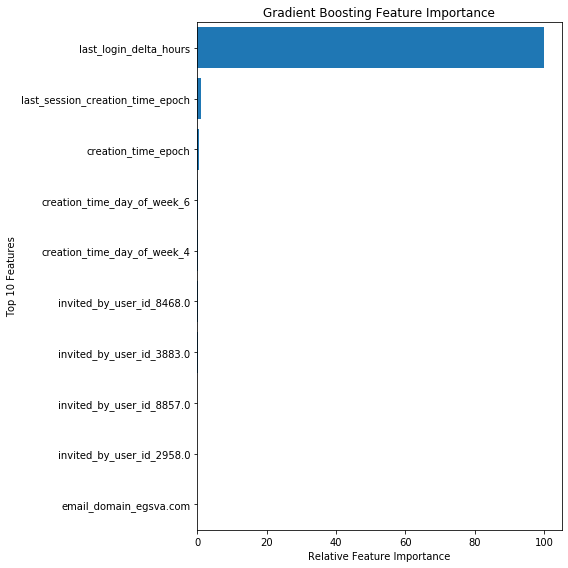

In [82]:
plot_top_features_imp(gb2, X_train_processed_2, 10)

The features last_login_delta_hours is correlated to login_count, so not surprising it is a top ranked feature once we eliminate login_count. See what happens without both of these features. 

In [84]:
X_train_processed_2 = X_train_processed.drop(columns=['login_count', 'last_login_delta_hours'])
X_test_processed_2 = X_test_processed.drop(columns=['login_count', 'last_login_delta_hours'])

In [85]:
class_names = ['Not Adopted', 'Adopted']
gb2 = GradientBoostingClassifier(random_state=42)
gb2.fit(X_train_processed_2, y_train)
y_pred_2 = gb2.predict(X_test_processed_2)
print(classification_report(y_pred_2, y_test, target_names = class_names))

              precision    recall  f1-score   support

 Not Adopted       0.99      0.96      0.98      3210
     Adopted       0.75      0.95      0.84       390

    accuracy                           0.96      3600
   macro avg       0.87      0.96      0.91      3600
weighted avg       0.97      0.96      0.96      3600



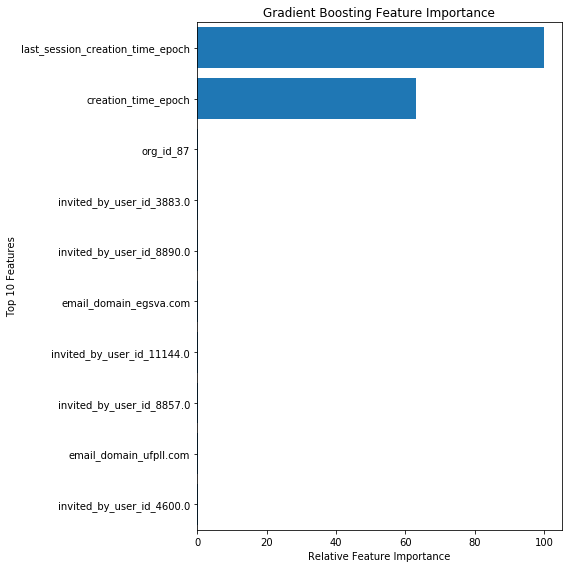

In [86]:
plot_top_features_imp(gb2, X_train_processed_2, 10)

After removing login_count and last_login_delta_hours, the model's top features are last_session_creation_time_epoch and creation_time_epoch. Not surprising, as last_login_delta_hours is calculated from max(time_stamp), which is equal to last_session_creation_time, minus creation_time. No other features are useful, and F1-score for the Adopted class has gone down to 0.84.  